In [1]:
from SRC_lstm import *

In [2]:
#df = get_prod_data()
#df = process_data(df)
#df_dummy = create_encoding_matrix(df)
#make_tensors(df)

# Load in the Data

In [3]:
well_life, np_gas, np_water, np_casing, np_tubing, np_static, np_choke, df_dummy, np_gas_norm, np_water_norm, \
    np_casing_norm, np_tubing_norm, np_static_norm, np_choke_norm = load_tensors()

# Confirm that CUDA Functions

In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1070 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Now we need to combine the normalized data into the joined dataset

In [5]:
#poop = [i for i in range(10)]

In [6]:
# def make_chunks(poop):
#     for i in poop:
#         yield i

In [7]:
#For the sake of memory management we will only use the first portion of the joined data set.  
#This is OK because most of the final dataset are null values that were imputed with 0

np_gas_norm = np_gas_norm[:,:1200]

In [8]:
#We will combine the following information:
#normalized gas rate
#normalized water rate
#normalized casing pressure
#normalized static pressure
#normalized tubing pressure
#normalized choke

types_of_input = 6
joined = np.empty((np_gas_norm.shape[0], np_gas_norm.shape[1]*types_of_input), 'float64')

#Iterate through all time steps and concatenate the datasets
for i in range(np_gas_norm.shape[1]):
    joined[:,types_of_input*i] = np_gas_norm[:,i]
    joined[:,types_of_input*i+1] = np_water_norm[:,i]
    joined[:,types_of_input*i+2] = np_casing_norm[:,i]
    joined[:,types_of_input*i+3] = np_tubing_norm[:,i]
    joined[:,types_of_input*i+4] = np_static_norm[:,i]
    joined[:,types_of_input*i+5] = np_choke_norm[:,i]

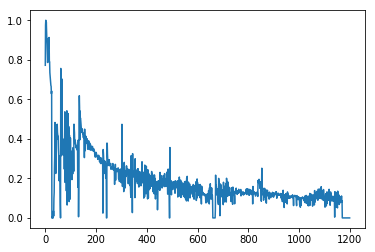

In [9]:
#We are able to effectively regenerate the input data
test = regenerate_gas_rate(joined, types_of_input)
fig = plt.plot(test[0])

In [10]:
#Define the input nodes
num_vars = 6 #sources of data
length = 30 #days of values to look at
dummy_vars = df_dummy.shape[1] #number of dummy variables in the input

input_nodes = num_vars * length + df_dummy.shape[1]

In [11]:
#Number of wells we plan to analyze
number_of_wells = joined.shape[0]

In [12]:
#Define the input, test, and target
data = torch.from_numpy(joined[:number_of_wells, :-num_vars*1])
data = data.to(device)

test_input = torch.from_numpy(joined[:3, :-num_vars*1])
test_input = test_input.to(device)

target = torch.from_numpy(np_gas_norm[:number_of_wells, length*1:])
target = target.to(device)

test_target = torch.from_numpy(np_gas_norm[:3, length*1:])
test_target = test_target.to(device)

In [13]:
target.shape

torch.Size([302, 1170])

# Run the Model on the GPU

In [14]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import pickle
import pandas as pd

class Sequence(nn.Module):
    
    def __init__(self, input_nodes):
        super(Sequence, self).__init__()
        
        self.input_nodes = input_nodes
        self.output_nodes = num_vars
        
        self.number_of_nodes_1 = input_nodes//2
        self.number_of_nodes_2 = self.number_of_nodes_1//2
        self.number_of_nodes_3 = self.number_of_nodes_2//2
        
        self.lstm1 = nn.LSTMCell(self.input_nodes, self.number_of_nodes_1)
        self.lstm2 = nn.LSTMCell(self.number_of_nodes_1, self.number_of_nodes_2)
        self.lstm3 = nn.LSTMCell(self.number_of_nodes_2, self.number_of_nodes_3)
        self.linear = nn.Linear(self.number_of_nodes_3, self.output_nodes)
        print("Sequence Model Initialized")
           
    def forward(self, data, future = 0):
        outputs = []
        
        h_t = torch.zeros(data.size(0), self.number_of_nodes_1, device=device, dtype=torch.double)
        c_t = torch.zeros(data.size(0), self.number_of_nodes_1, device=device, dtype=torch.double)
        h_t2 = torch.zeros(data.size(0), self.number_of_nodes_2, device=device, dtype=torch.double)
        c_t2 = torch.zeros(data.size(0), self.number_of_nodes_2, device=device, dtype=torch.double)
        h_t3 = torch.zeros(data.size(0), self.number_of_nodes_3, device=device, dtype=torch.double)
        c_t3 = torch.zeros(data.size(0), self.number_of_nodes_3, device=device, dtype=torch.double)

        #Break the data up into chunks where we can determine the number of input nodes
        #We exclude the df_dummy shape as that must be added in for each input
        number_of_chunks = data.shape[1] - (self.input_nodes - df_dummy.shape[1] - num_vars*1)
        
        for i in range(number_of_chunks//(num_vars*1)):
            
            #Break the data into each chunk
            input_t = data[:,num_vars*1*i:num_vars*1*i+(input_nodes-df_dummy.shape[1])]
            
            #print(input_t.shape)
            #print(torch.tensor(df_dummy.values,dtype=torch.float64).shape)
                  
            #Here we now add in the non-changing matrix of categorical variables stored in df_dummy
            input_t = torch.cat((input_t,torch.tensor(df_dummy.iloc[:input_t.shape[0],:].values, 
                                                      device=device, dtype=torch.float64)),1)
            
            #print(input_t.shape)
            
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3))
            output = self.linear(h_t3)
            outputs += [output]
                  
        for i in range(future): # if we should predict the future
            #Output is num_vars (6)
            output = outputs[-(self.input_nodes-df_dummy.shape[1])//(num_vars):]
            #print(len(output))
            output = torch.stack(output, 1)
            #print(output.shape)
            output = output.reshape(output.shape[0],output.shape[1]*output.shape[2])
            #print(output.shape)
            #output = output[:number_of_wells,-num_vars*length:]
            #print(output.shape)
            
            #We need to add back in the df_dummy
            output = torch.cat((output,torch.tensor(df_dummy.iloc[:output.shape[0],:].values,
                                                    device=device, dtype=torch.float64)),1)
            #output = np.hstack((output,df_dummy.iloc[:number_of_wells,:].values))
            
            #print("torch tensor concatenated with df_dummy")
            #print(output.shape)
            
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3))
            output = self.linear(h_t3)
            outputs += [output]
        
        outputs = torch.stack(outputs, 1)
        outputs = outputs.reshape(outputs.shape[0],outputs.shape[1]*outputs.shape[2])
        #print(outputs.shape)
        #outputs = torch.stack(outputs, 1).reshape((1,self.output_nodes*len(outputs)))
        return outputs

In [15]:
#View the shapes of the inputs and targets
print(joined.shape)
print(data.shape, target.shape, test_input.shape, test_target.shape)

(302, 7200)
torch.Size([302, 7194]) torch.Size([302, 1170]) torch.Size([3, 7194]) torch.Size([3, 1170])


In [16]:
def mask_output(out, target, well_life):
    """Any well item that has a length greater than its duration from the well_list is maked from the target"""
    for i, well in enumerate(well_life):
        out[i,6*well:] = target[i,6*well:]
    return out

def mask_zeros(out, target, well_life):
    """If the target gas rate is 0, ignore the value"""
    for i, well in enumerate(well_life):
        for gas_rate in range(i):
            if(target[i, 6*gas_rate] == 0):
                out[i,6*gas_rate] = 0
    return out
    

In [17]:
def closure():
    optimizer.zero_grad()
    #Output predicts the next values
    out = seq(data)
    #print("in closure:", out.shape, target.shape)
    
    #We can apply a mask here on the output function if the values should be zeros or exceed current well life
    #out = mask_output(out, target, well_life)
    #out = mask_zeros(out, target, well_life)
    
    loss = criterion(regenerate_gas_rate(out, types_of_input), target)
    print('loss:', loss.item())
    loss.backward()
    return loss

def draw(yi, color):
    plt.plot(np.arange(np_gas_norm.shape[1]), yi[:np_gas_norm.shape[1]], color, linewidth = 2.0)
    plt.plot(np.arange(np_gas_norm.shape[1], np_gas_norm.shape[1] + future - length), yi[np_gas_norm.shape[1]:], color + ':', linewidth = 2.0)

def iteration_plot(y):
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    draw(y[0], 'r')
    draw(y[1], 'b')
    draw(y[2], 'g')
    plt.savefig('gas/predict_iteration_%d.pdf'%i)
    plt.close()

In [18]:
iterations = 30

# build the model
seq = Sequence(input_nodes)
seq.double()
seq.cuda()

criterion = nn.MSELoss()

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=1)

#begin to train
for i in range(iterations):
    #Change the learning rate each Epoch
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] / (1.15)
        print("Learning Rate: ", param_group['lr'])

    print('EPOCH: ', i)

    optimizer.step(closure)
    
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 50 #1000
        pred = seq(test_input, future=future)
        loss = criterion(regenerate_gas_rate(pred[:, :-(num_vars*future)], types_of_input), 
                         test_target)
        print('test loss:', loss.item())
        y = pred.detach().cpu().numpy()
        y = regenerate_gas_rate(y, types_of_input)
    
    # draw the result
    iteration_plot(y)
    
    #Save the model
    with open('gas_forecast.pickle', 'wb') as handle:
        pickle.dump(seq, handle, protocol=pickle.HIGHEST_PROTOCOL)

Sequence Model Initialized
Learning Rate:  0.8695652173913044
EPOCH:  0


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [ ]:
%debug

In [ ]:
import pickle
#with open('gas_forecast.pickle', 'wb') as handle:
#    pickle.dump(seq, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('gas_forecast.pickle', 'rb') as handle:
    seq = pickle.load(handle)

# Need to create forecasts for all wells but only from the last actual from well_life

In [ ]:
#Create Predictions for all coins
criterion = nn.MSELoss()

with torch.no_grad():
    future = 1000
    pred = seq(data, future=future)
    loss = criterion(pred[:, :-(6*future)], target)
    y = pred.detach().cpu().numpy()

    #y1, y2, y3, y4, y5, y6 = regenerate_all(y, types_of_input)

In [ ]:
#Transform the predictions back to the gas rate values
y1_transformed = y1 * np.linalg.norm(np_gas, ord=np.inf, axis=1, keepdims=True)
y2_transformed = y2 * np.linalg.norm(np_water, ord=np.inf, axis=1, keepdims=True)
y3_transformed = y3 * np.linalg.norm(np_casing, ord=np.inf, axis=1, keepdims=True)
y4_transformed = y4 * np.linalg.norm(np_tubing, ord=np.inf, axis=1, keepdims=True)
y5_transformed = y5 * np.linalg.norm(np_static, ord=np.inf, axis=1, keepdims=True)
y6_transformed = y6 * np.linalg.norm(np_choke, ord=np.inf, axis=1, keepdims=True)

In [ ]:
well_life[0]

In [ ]:
y.shape[1]//6

In [ ]:
np_gas.shape

In [ ]:
def draw_figures(y, well_life, np_gas, np_water, np_casing, np_tubing, np_static, np_choke, future=0):
    #Create a figure for each ticker
    y1, y2, y3, y4, y5, y6 = regenerate_all(y, types_of_input)
    
    #Transform the predictions back to the gas rate values
    y1_transformed = y1 * np.linalg.norm(np_gas, ord=np.inf, axis=1, keepdims=True)
    y2_transformed = y2 * np.linalg.norm(np_water, ord=np.inf, axis=1, keepdims=True)
    y3_transformed = y3 * np.linalg.norm(np_casing, ord=np.inf, axis=1, keepdims=True)
    y4_transformed = y4 * np.linalg.norm(np_tubing, ord=np.inf, axis=1, keepdims=True)
    y5_transformed = y5 * np.linalg.norm(np_static, ord=np.inf, axis=1, keepdims=True)
    y6_transformed = y6 * np.linalg.norm(np_choke, ord=np.inf, axis=1, keepdims=True)
    
    for i, duration in enumerate(well_life):
        
        # draw the result
        plt.figure(figsize=(30,10))
        plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        
        #plot the historical values
        plt.plot(np.arange(well_life[i]), np_gas[i, :well_life[i]], 'r', linewidth = 2.0, label='gas')
        plt.plot(np.arange(well_life[i]), np_water[i, :well_life[i]], 'b', linewidth = 2.0, label='water')
        plt.plot(np.arange(well_life[i]), np_casing[i, :well_life[i]], 'g', linewidth = 2.0, label='casing')
        plt.plot(np.arange(well_life[i]), np_water[i, :well_life[i]], 'c', linewidth = 2.0, label='tubing')
        plt.plot(np.arange(well_life[i]), np_water[i, :well_life[i]], 'y', linewidth = 2.0, label='static')
        plt.plot(np.arange(well_life[i]), np_water[i, :well_life[i]], 'k', linewidth = 2.0, label='choke')
        
        #Plot the predicted future values
        plt.plot(np.arange(well_life[i],well_life[i]+future), y1_transformed[i, -future:], 'r-', linewidth = 2.0, label='gas')
        plt.plot(np.arange(well_life[i],well_life[i]+future), y2_transformed[i, -future:], 'b-', linewidth = 2.0, label='water')
        plt.plot(np.arange(well_life[i],well_life[i]+future), y3_transformed[i, -future:], 'g-', linewidth = 2.0, label='casing')
        plt.plot(np.arange(well_life[i],well_life[i]+future), y4_transformed[i, -future:], 'c-', linewidth = 2.0, label='tubing')
        plt.plot(np.arange(well_life[i],well_life[i]+future), y5_transformed[i, -future:], 'y-', linewidth = 2.0, label='static')
        plt.plot(np.arange(well_life[i],well_life[i]+future), y6_transformed[i, -future:], 'k-', linewidth = 2.0, label='choke')
        
        plt.savefig('well_graphs/' + str(i) + '.pdf')
        plt.close()

In [ ]:
draw_figures(y, well_life, np_gas, np_water, np_casing, np_tubing, np_static, np_choke, future)

In [ ]:
#Predicted Top Performers
top_df = result_df.sort_values('24_hr_percent', ascending=False)[0:10]
#Create a graph of the top 10 performers
draw_figures(pred_transformed, top_df, 1000, "top_performers_")
draw_all_figures(pred_transformed, top_df, 1000, "top_performers")

top_df.style.format({
    '24_hr_percent': '{:.2%}'.format,
    '48_hr_percent': '{:.2%}'.format,
    '168_hr_percent': '{:.2%}'.format
})